<a href="https://colab.research.google.com/github/jleugr/k/blob/main/k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# rethinking pack for tensorflow prob includes a sample_posterior function that we want to use
try:
  import google.colab
  %pip install git+https://github.com/ksachdeva/rethinking-tensorflow-probability.git
except:
  pass

  Cloning https://github.com/ksachdeva/rethinking-tensorflow-probability.git to /tmp/pip-req-build-22ahg5jc
  Running command git clone -q https://github.com/ksachdeva/rethinking-tensorflow-probability.git /tmp/pip-req-build-22ahg5jc


In [ ]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

from rethinking.mcmc import sample_posterior
from rethinking.data import dataframe_to_tensors #delete if not useful



%config InlineBackend.figure_format = 'retina'
%matplotlib inline

tfd = tfp.distributions
tfb = tfp.bijectors

dtype = tf.float64
Root = tfd.JointDistributionCoroutine.Root
tf.compat.v1.enable_eager_execution()

setting some constant variables (height of parks (in meters) plus some general atmospheric effects that don't change)

In [ ]:
#t mobile ht = 14 ft/4.2672m
ht_1=tf.constant([4.2672], dtype=tf.float32)

#coors field ht = 5200 ft/1584.96 m
ht_2=tf.constant([1584.96], dtype=tf.float32)

#busch ht = 436 ft/132.893 m
ht_3=tf.constant([132.893], dtype=tf.float32)


hts=[ht_1, ht_2, ht_3]

#approximate area and mass of a baseball 
b_a=tf.constant([27.2619], dtype=tf.float32)
b_d=tf.constant([70.2697], dtype=tf.float32)

#this stuff are assorted variables for the air density formulas, see reference for more info.
g=tf.constant([32.17405], dtype=tf.float32)
rs=tf.constant([8.9494596*10**4], dtype=tf.float32)
M=tf.constant([28.9644], dtype=tf.float32)
p1=tf.constant([101325.00], dtype=tf.float32)
t1=tf.constant([288.15], dtype=tf.float32)
l1=tf.constant([-0.0019812], dtype=tf.float32)
Mv=tf.constant([0.039718481155], dtype=tf.float32)



generate data here for temperature (in celsius) plus humidity
the intervals for exit velocity and launch angle are as per MLB's barreled ball expected values. \
because baseball is played through the spring/summer/fall temperature may be below 50 degrees or above 95 degrees (F). however most of the season is in the summer and we can reasonably expect it to be warmer, probably more like between 65 and 95. this is a general guess for 3 seperate ballparks.\
humidity is tricky but baseball isnt played in the rain (>.9 percent) and even in summer in denver humidity probably isnt lower than .2. these are just guesses.  


In [ ]:
tf.random.set_seed(4)
hum=tf.random.uniform([4,20], minval=.2, maxval=.9, dtype=tf.float32)
temp=tf.random.uniform([4, 20], minval=18.5, maxval=35, dtype=tf.float32)


k = 1/2 *ph*(a/m). the formulas to calculate *ph* are below (this is the total pressure of humid air.) we want to simulate priors for temperature and humidity so we can model probabilities of *k*, the total effect of local atmposhere on the baseball with no wind.\


In [ ]:
#model for saturation vapor pressure of water @specific air temperature 
#psat=6.1078*10**((7.5*temp)/(temp+237.5))

#models for pressure of air @ height (this only depends on elevation/height which is constant for each ballpark)
#so we can just go ahead and calcualte them right quick. as u can see dry air pressure at t mobile park in seattle is a bigger number than the others.
#this is because it's very close to sea level.
#ph1=p1*((t1+ht_1*l1)/(t1))**((-g*M)/(rs*l1))
#ph2=p1*((t1+ht_2*l1)/(t1))**((-g*M)/(rs*l1))
#ph3= p1*((t1+ht_3*l1)/(t1))**((-g*M)/(rs*l1))

#phts=[ph1, ph2, ph3]
#plt.hist(hts, phts, color=["black", "black", "black"])


#partial pressure of dry air
#pd=pa-psat

#vapor pressure of water
#pv=hum*psat

#total air pressure of humid air @given temperature, humidity, height
#ph=((pd*M+pv*Mv)/(rs*t1))

#actual thing we will actually use but later
#ph_f=(((pa_1-hum*6.1078*10**((7.5*temp)/(temp+237.5)))*M)+((hum*6.1078*10**((7.5*temp)/(temp+237.5)))*Mv))/(rs*t1)



In [ ]:

def model_2():
    def _generator():
        #humidity is distributed between 0 and 1 
        hum_pr = yield Root(tfd.Sample(tfd.Uniform(low=0.20, high=.90, name="hum"), sample_shape=(1)))
        #because most MLB games are played in the summer, for now assume temp is normally distributed wih mean 85 degrees F/29.5 C and variance 2 degree
        temp_pr = yield Root(tfd.Sample(tfd.Normal(29.5, 2, name="temp"), sample_shape=(1)))
        

        term1=((7.5*temp_pr)/(temp_pr+237.5))
        term2 = hum_pr * 6.1078*10**term1

        mu=tf.math.log((1/25787867.84*term2[...,tf.newaxis]*0.039718481155)+(101309.38-term2[...,tf.newaxis]*28.9644))

        #assumed an exponential dist for ph because generally as temp and humidity go up air density goes down
        ph_ = yield tfd.Independent(
            tfd.Exponential(rate=mu), reinterpreted_batch_ndims= 1
        )
           
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)


jdc_2 = model_2()


In [ ]:
jdc_2.sample()
#n: there isn't much variance for temperature right now, fix later. 
#resulting ph looks not right


StructTuple(
  var0=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.3347384], dtype=float32)>,
  var1=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([29.891304], dtype=float32)>,
  var2=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.05917593]], dtype=float32)>
)

above, a single sample from m2. not easy to tell what it means at first glance. the way this works is that the model samples in reverse so the last tensor u see is returning the joint probability of the 2 previous variables from the generator. var0 and var1 are samples from the priors for temperature and humidity.

in general irl we expect more humid air to be less dense and hotter air to be less dense so on a warmer, humid day the air density should be lower.

anyway now we can finally define the MCMC object and hopefully do some sampling. this is also not very straightforward.


In [ ]:
# the notebook i blatantly copied this code from suggested using the initial vals from the model itself instead of zeros for better sampling
NUM_CHAINS_FOR_m2 = 4
hum_p_in, temp_p_in,  _ = jdc_2.sample()

init_state = [
    tf.tile(hum_p_in, (NUM_CHAINS_FOR_m2,)),
    tf.tile(temp_p_in, (NUM_CHAINS_FOR_m2,)),
]


bijectors = [
    tfb.Identity(),
    tfb.Exp(),
]

#this is where that sample_posterior() function is used and the observed_data comes out of the simulated data from a few chunks ago.
posterior_m2, trace_m2= sample_posterior(
    jdc_2,
    observed_data=(hum,temp),
    params=["hum", "temp"],
    init_state=init_state,
    bijectors=bijectors,
)


some model diagnostics:

In [ ]:

#note rhat is too high, not good, but not super high. lots of samples for humidity are in the tails so we probably need to think about that.

az.summary(trace_m2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hum,0.617,0.196,0.266,0.876,0.066,0.049,10.0,27.0,1.34
temp,29.595,2.552,25.220,34.403,0.193,0.137,190.0,10.0,1.28


trace plots below look unsatisfying, we can probably do better than this so time to revise the model

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae64ee6e10>,
      dtype=object)

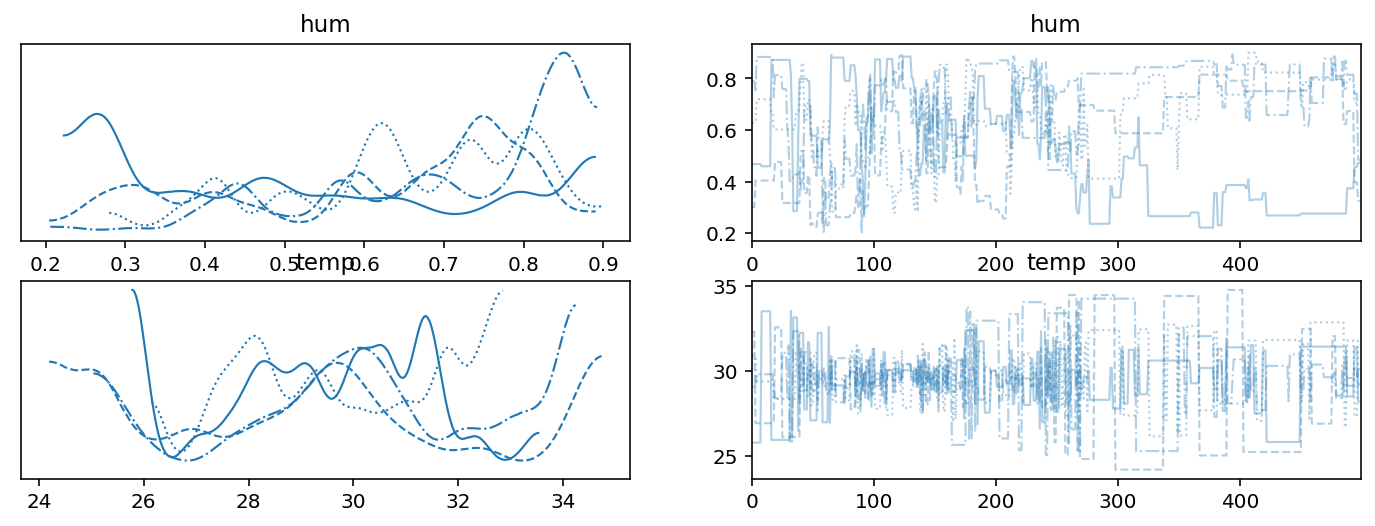

In [ ]:
az.plot_trace(trace_m2, filter_vars="like")

humidity needs to be more centered. temp probably just needs a stronger prior.

*you may be wondering why we jumped from model 2 to model 4. model 3 was a disaster child lognormal based distribution which i deleted after building it because it somehow used up the entire RAM for the notebook whenever it ran.

In [ ]:
def model_4():
    def _generator():
        #humidity might work better as a normal distribution instead of a uniform. 
        #average humidity is probably closer to .9 than it is to .2 since we aren't playing baseball in death valley. picked a mean of .6 and a 
        #variance of 10 percent (this is just a guess)
        hum_pr4 = yield Root(tfd.Sample(tfd.Normal(0.60, .1, name="hum"), sample_shape=(1))) 
        #now using a normal distribution but a little more defined than last time. the new value for mean is just the expected 
        #value of the simulated data (roughly 75 deg F). we want more variance than last time also so blew it up. 
        temp_pr4 = yield Root(tfd.Sample(tfd.Normal(26.25, 5, name="temp"), sample_shape=(1)))
        #we dont need sigma for an exponential distribution
        
        #these tf.newaxis things do something idk what tho

        term1=((7.5*temp_pr4[...,tf.newaxis])/(temp_pr4+237.5))
        term2 = (hum_pr4[...,tf.newaxis] * (6.1078*10**term1[...,tf.newaxis]))

        mu3=tf.math.log(1/25787867.84*((term2[...,tf.newaxis]*0.039718481155)+(101309.38-term2*28.9644)))

        #previously assumed an exponential dist for ph because generally as temp and humidity go up air density goes down before. 
        #no obvious reason to change it
        

        ph_3 = yield tfd.Independent(
            tfd.Exponential(rate=-(mu3)), reinterpreted_batch_ndims= 3    
        )
           
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)


jdc_4 = model_4()


In [ ]:
jdc_4.sample()

StructTuple(
  var0=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.51097643], dtype=float32)>,
  var1=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([25.034712], dtype=float32)>,
  var2=<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[0.07101392]]]], dtype=float32)>
)

these samples don't look too bad and the returned ph is behaving like we expect. 

In [ ]:
NUM_CHAINS_FOR_m4 = 4
hum_p_in3, temp_p_in3,  _ = jdc_4.sample()

init_state = [
    tf.tile(hum_p_in3, (NUM_CHAINS_FOR_m4,)),
    tf.tile(temp_p_in3, (NUM_CHAINS_FOR_m4,)),
]

posterior_m4, trace_m4= sample_posterior(
    jdc_4,
    observed_data=(hum,temp),
    params=["hum", "temp"],
    init_state=init_state,
    bijectors=bijectors,
)


In [ ]:
az.summary(trace_m4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hum,0.604,0.090,0.451,0.771,0.008,0.006,116.0,38.0,1.04
temp,26.283,4.583,17.398,33.481,0.312,0.227,219.0,61.0,1.06


this result is better, rhat is still high but we can maybe fix this last issue by doing a few more draws. 

In [ ]:
hum_sh = trace_m4.posterior["hum"].values[0].shape
print(hum_sh)

#we drew 500 samples last time. standard number of draws in R is 5000 which seems excessive. we can maybe do like 3000 now just to see
#also set burnin to 500.

post_m4_2, trace_m4_2=sample_posterior(jdc_4,
    observed_data=(hum,temp),
    params=["hum", "temp"],
    init_state=init_state,
    bijectors=bijectors,
    num_samples=3000,
    burnin=500)

(500,)


In [ ]:
az.summary(trace_m4_2)

#looks solid 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hum,0.595,0.100,0.416,0.789,0.002,0.001,2790.0,2273.0,1.0
temp,26.180,4.852,15.973,34.699,0.073,0.057,4301.0,417.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae626ee9d0>,
      dtype=object)

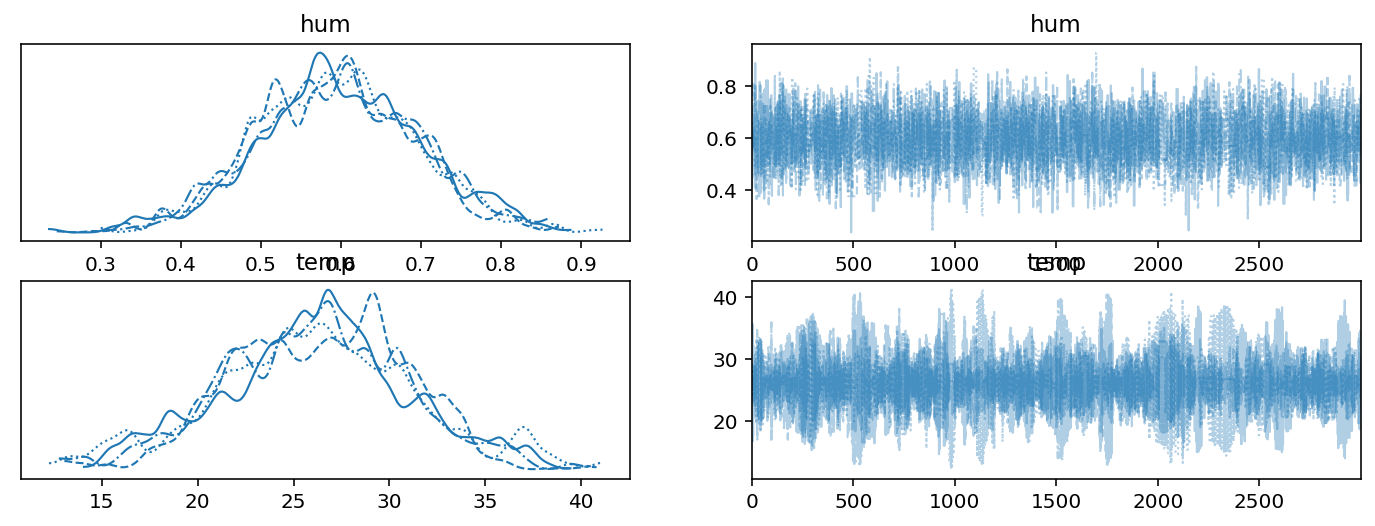

In [ ]:
az.plot_trace(trace_m4_2, filter_vars="like")

#we're in business, temp still a little rocky but not too bad.

one thing we need to change right quick is that we want as u will recall to sample for 3 different ballparks. we are going to define this variable inside the model code just to make things easy 

we just have to multiply it in. the laziest way to do this is just have 3 variables that u uncomment for whatever park you want. 

note: if any of the last 3 models have a very high rhat, wait 30 seconds or so and run them again and it'll work right the second time.

In [ ]:

def model_4b():
    def _generator():

        #we calculated these earlier and trained the model based on the mariners. we'll uncomment the rockies to simulate ph just for kicks.
        #mariners_p=101309.38
        rockies_p=95654.47
        #cards_p=100839.36

        hum_pr4b = yield Root(tfd.Sample(tfd.Normal(0.60, .1, name="hum"), sample_shape=(1))) 
        temp_pr4b = yield Root(tfd.Sample(tfd.Normal(26.25, 5, name="temp"), sample_shape=(1)))

        term1=((7.5*temp_pr4b[...,tf.newaxis])/(temp_pr4b+237.5))
        term2 = (hum_pr4b[...,tf.newaxis] * (6.1078*10**term1[...,tf.newaxis]))

        mu3b=tf.math.log(1/25787867.84*((term2[...,tf.newaxis]*0.039718481155)+(rockies_p-term2*28.9644)))
        
        ph_3 = yield tfd.Independent(
            tfd.Exponential(rate=(mu3b)), reinterpreted_batch_ndims= 3    
        )
          
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

jdc_4b = model_4b()


#this is all stuff we already did

NUM_CHAINS_FOR_m4b = 4
hum_p_in4b, temp_p_in4b,  _ = jdc_4b.sample()

init_state = [
    tf.tile(hum_p_in4b, (NUM_CHAINS_FOR_m4b,)),
    tf.tile(temp_p_in4b, (NUM_CHAINS_FOR_m4b,)),
]

post_m4b, trace_m4b=sample_posterior(jdc_4b,
    observed_data=(hum,temp),
    params=["hum", "temp"],
    init_state=init_state,
    bijectors=bijectors,
    num_samples=3000,
    burnin=500)

quick check to make sure the model didn't mess up on us and then were going to sample ph from the simulated data

In [ ]:
az.summary(trace_m4b)

/usr/local/lib/python3.7/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hum,0.455,0.0,0.455,0.455,0.0,0.0,12000.0,12000.0,NaN
temp,17.429,0.0,17.429,17.429,0.0,0.0,12000.0,12000.0,NaN


In [ ]:
#no change 
#heres a look at our first few sampled values for humidity and temperature
hum_sim = trace_m4b.posterior["hum"].values[0]
print("humidity values= ", hum_sim[1:10])

temp_sim = trace_m4b.posterior["temp"].values[0]
print("temperature values", temp_sim[1:10])

def ph_from_samples(hum_sim, temp_sim):
    #mariners_p=101309.38
    rockies_p=95654.47
    #cards_p=100839.36
    term1=((7.5*temp_sim)/(temp_sim+237.5))
    term2 = (hum_sim * (6.1078*10**term1))
    mu3_s=(1/25787867.84*((term2*0.039718481155)+(rockies_p-term2*28.9644)))
    return tfd.Exponential(rate=mu3_s).sample().numpy()

ph_sim=ph_from_samples(hum_sim, temp_sim)

print("air pressure values=", ph_sim[1:30])


humidity values=  [0.45463365 0.45463365 0.45463365 0.45463365 0.45463365 0.45463365
 0.45463365 0.45463365 0.45463365]
temperature values [17.428797 17.428797 17.428797 17.428797 17.428797 17.428797 17.428797
 17.428797 17.428797]
air pressure values= [ 19.80852  119.255264  47.341553 222.8707    22.137741  68.85678
 255.48125  192.99576  589.1383   129.65211  587.76355  100.11052
 135.51372   34.939205 199.071     56.874214 703.9057    85.14121
 449.73068   65.408875  66.20007  710.6827   121.33342  118.62906
 167.79709  156.24522  170.14743  505.00272  390.2437  ]


In [ ]:
#we need 2 more sets, one for t mobile (already did) and one for busch so we can build datasets for k. 

def model_4c():
    def _generator():

      
        #mariners_p=101309.38
        #rockies_p=95654.47
        cards_p=100839.36

        hum_pr4c = yield Root(tfd.Sample(tfd.Normal(0.60, .1, name="hum"), sample_shape=(1))) 
        temp_pr4c = yield Root(tfd.Sample(tfd.Normal(26.25, 5, name="temp"), sample_shape=(1)))

        term1=((7.5*temp_pr4c[...,tf.newaxis])/(temp_pr4c+237.5))
        term2 = (hum_pr4c[...,tf.newaxis] * (6.1078*10**term1[...,tf.newaxis]))

        mu3c=tf.math.log(1/25787867.84*((term2[...,tf.newaxis]*0.039718481155)+(cards_p-term2*28.9644)))
        
        ph_c = yield tfd.Independent(
            tfd.Exponential(rate=-(mu3c)), reinterpreted_batch_ndims= 3    
        )
          
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

jdc_4c = model_4c()


#this is all stuff we already did

NUM_CHAINS_FOR_m4c = 4
hum_p_in4c, temp_p_in4c,  _ = jdc_4c.sample()

init_state = [
    tf.tile(hum_p_in4c, (NUM_CHAINS_FOR_m4c,)),
    tf.tile(temp_p_in4c, (NUM_CHAINS_FOR_m4c,)),
]

post_m4c, trace_m4c=sample_posterior(jdc_4c,
    observed_data=(hum,temp),
    params=["hum", "temp"],
    init_state=init_state,
    bijectors=bijectors,
    num_samples=3000,
    burnin=500)

In [ ]:
az.summary(trace_m4c)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hum,0.584,0.093,0.422,0.756,0.008,0.006,125.0,71.0,1.03
temp,26.270,4.617,17.620,34.256,0.479,0.340,92.0,59.0,1.06


In [ ]:
#mariners ph 
hum_sim_b = trace_m4.posterior["hum"].values[0]
print("humidity values= ", hum_sim_b[1:10])

temp_sim_b = trace_m4.posterior["temp"].values[0]
print("temperature values", temp_sim_b[1:10])

def ph_from_samples_2(hum_sim_b, temp_sim_b):
    mariners_p=101309.38
    #rockies_p=95654.47
    #cards_p=100839.36
    term1=((7.5*temp_sim_b)/(temp_sim_b+237.5))
    term2 = (hum_sim_b * (6.1078*10**term1))
    mu3_sb=tf.math.log(1/25787867.84*((term2*0.039718481155)+(mariners_p-term2*28.9644)))
    return tfd.Exponential(rate=mu3_sb).sample().numpy()

ph_sim_b=ph_from_samples_2(hum_sim_b, temp_sim_b)

print("air pressure values=", ph_sim_b[1:30])


humidity values=  [0.73291135 0.61037564 0.6529474  0.6198984  0.6198984  0.60453904
 0.66398066 0.6062755  0.6653263 ]
temperature values [22.417578 31.401377 23.109985 30.588913 30.588913 23.152367 29.590626
 21.305605 31.989977]
air pressure values= [-0.08007978 -0.05885518 -0.03672296 -0.04394558 -0.11711477 -0.07667233
 -0.11926718 -0.3228714  -0.19170083 -0.12505671 -0.49207893 -0.00117818
 -0.05984683 -0.0229786  -0.39676705 -0.00173366 -0.14727996 -0.18916695
 -0.04686888 -0.05220996 -0.4886567  -0.6598523  -0.10339086 -0.23070465
 -0.04694478 -0.37046248 -0.7137639  -0.08206461 -0.87229323]


In [ ]:
#cardinals ph

hum_sim_c = trace_m4c.posterior["hum"].values[0]
print("humidity values= ", hum_sim_c[1:10])

temp_sim_c = trace_m4c.posterior["temp"].values[0]
print("temperature values", temp_sim_c[1:10])

def ph_from_samples_3(hum_sim_c, temp_sim_c):
    #mariners_p=101309.38
    #rockies_p=95654.47
    cards_p=100839.36
    term1=((7.5*temp_sim_c)/(temp_sim_c+237.5))
    term2 = (hum_sim_c * (6.1078*10**term1))
    mu3_sc=(1/25787867.84*((term2*0.039718481155)+(cards_p-term2*28.9644)))
    return tfd.Exponential(rate=mu3_sc).sample().numpy()

ph_sim_c=ph_from_samples_3(hum_sim_c, temp_sim_c)

print("air pressure values=", ph_sim_c[1:30])




humidity values=  [0.5709003 0.5709003 0.5709003 0.5709003 0.5709003 0.5709003 0.5709003
 0.5709003 0.5709003]
temperature values [40.330135 40.330135 40.330135 40.330135 40.330135 40.330135 40.330135
 40.330135 40.330135]
air pressure values= [  83.57812    408.46295    377.20697      6.524763   584.0904
  116.886406    71.679665     7.431057   102.76926    139.33679
  110.864815   163.12993      7.7191486 1444.7557      31.20426
  329.8947     200.13092     34.92208    258.424      422.66525
  429.39227    253.57414    441.7398      54.008366   545.8919
   81.94555    867.1943      37.25696     35.28827  ]


final step is converting these humidity values to the actual variable we need to simulate (k). we then want to write to .csv for convenience reasons.  

as a reminder k=ph/2(ball areaarea/ball mass)

In [ ]:
#we are going to keep using millibars because our area and mass measurements are in millimeters
k_mariners=(ph_sim_b/2)*(b_a/b_d)
print(k_mariners[1:30])
k_rockies=(ph_sim/2)*(b_a/b_d)
print(k_rockies[1:30])
k_cards=(ph_sim_c/2)*(b_a/b_d)
print(k_cards[1:30])


tf.Tensor(
[-0.01553391 -0.01141676 -0.00712354 -0.00852459 -0.02271798 -0.01487294
 -0.02313551 -0.06263075 -0.03718622 -0.02425856 -0.09545371 -0.00022854
 -0.01160912 -0.0044574  -0.07696506 -0.0003363  -0.02856944 -0.0366947
 -0.00909165 -0.01012771 -0.09478986 -0.12799847 -0.02005581 -0.0447522
 -0.00910637 -0.07186249 -0.13845627 -0.01591893 -0.16920787], shape=(29,), dtype=float32)
tf.Tensor(
[  3.842466   23.133194    9.183337   43.232567    4.2942896  13.356872
  49.558376   37.437412  114.281334   25.14998   114.014656   19.419487
  26.287016    6.777524   38.61589    11.032488  136.54398    16.515734
  87.238976   12.6880455  12.841522  137.85857    23.536316   23.011723
  32.549362   30.308525   33.00528    97.96067    75.69966  ], shape=(29,), dtype=float32)
tf.Tensor(
[ 16.212524   79.23384    73.17079     1.2656767 113.30214    22.673681
  13.904456    1.44148    19.93523    27.028618   21.505611   31.644022
   1.4973642 280.25443     6.0530176  63.993137   38.82149     

we could do some plots to make this easier to think about

In [ ]:
#unsurprisingly, writing a tensor to csv is a huge pain so we are converting these to nparrays first
m_k=k_mariners.numpy()
r_k=k_rockies.numpy()
c_k=k_cards.numpy()

In [ ]:

#then for ease of access for future use we can send them to seperate .csvs right in the google drive
#from google.colab import  drive
#only unmute drive.mount once or it gets mad and yells at u)
#drive.mount('/drive')

#(unmute to write to a file)
#pd.DataFrame(m_k).to_csv('/drive/My Drive/project_csvs/mariners_k.csv')
#pd.DataFrame(r_k).to_csv('/drive/My Drive/project_csvs/rockies_k.csv')
#pd.DataFrame(c_k).to_csv('/drive/My Drive/project_csvs/cardinals_k.csv')
#pd.DataFrame(c_k).to_csv('/drive/My Drive/project_csvs/clt_k.csv')